<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/02.%20Deep%20Learning/01.%20Week%201/Notebooks/02.mnist_neural_network_intuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks on MNIST: What Do Hidden Layers Actually Learn?

**The "Hello World" of Deep Learning**

Di notebook sebelumnya, kita sudah lihat bagaimana Neural Network bisa learn non-linear decision boundaries. Sekarang, kita akan:

1. Apply neural network ke **real image data** (MNIST handwritten digits)
2. Memahami **apa yang sebenarnya dipelajari** oleh hidden layers
3. Visualisasi: Hidden layers sebagai **feature extractors**

---

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
# Part 1: Mengenal MNIST Dataset

MNIST adalah dataset klasik berisi **70,000 gambar tulisan tangan angka 0-9**.
- Training set: 60,000 images
- Test set: 10,000 images
- Ukuran gambar: 28×28 pixels (grayscale)

In [2]:
# Download dan load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 47.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.38MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.20MB/s]


Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


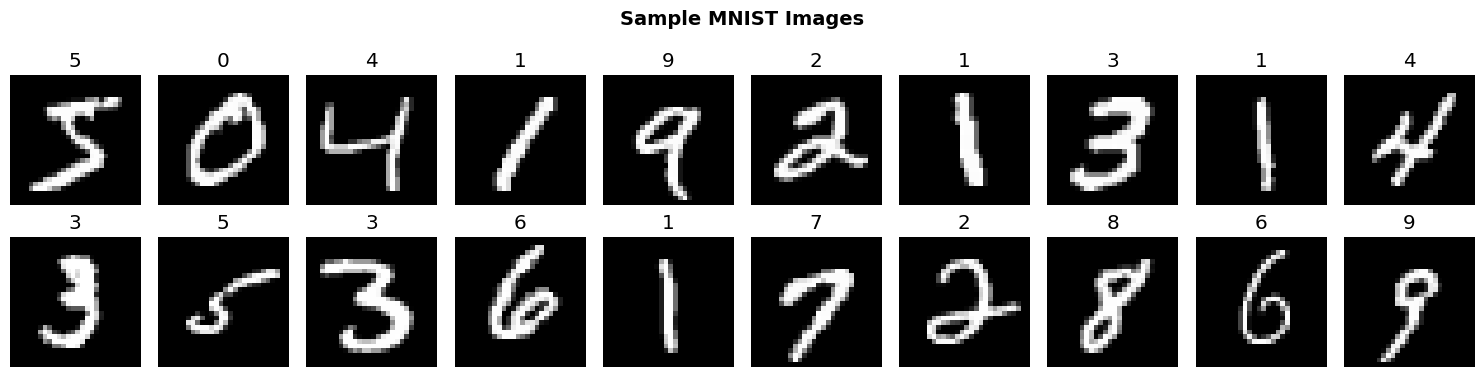

In [3]:
# Visualisasi beberapa contoh
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(20):
    ax = axes[i // 10, i % 10]
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'{label}')
    ax.axis('off')

plt.suptitle('Sample MNIST Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

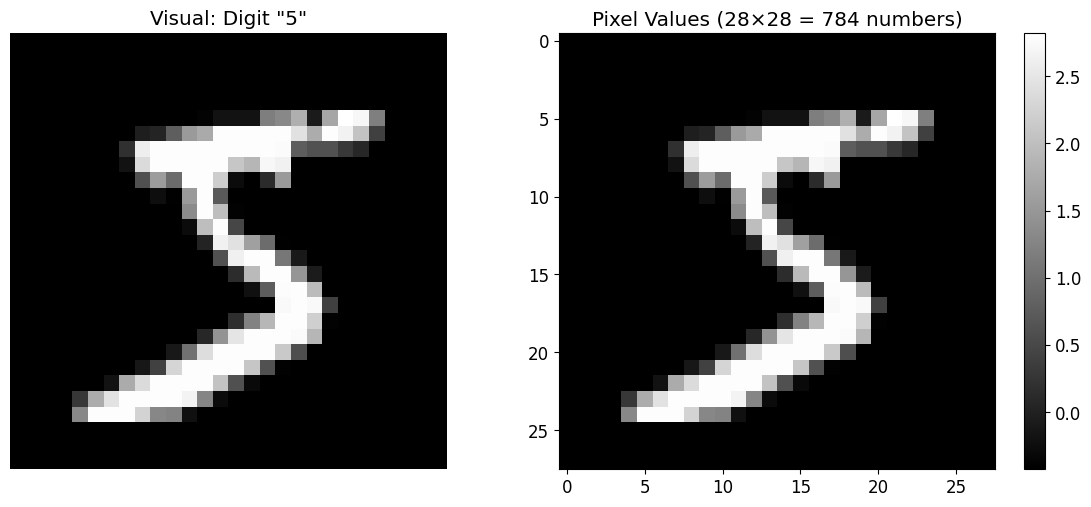

Image shape: torch.Size([1, 28, 28])
Min pixel value: -0.424
Max pixel value: 2.821


In [4]:
# Lihat satu gambar lebih detail
sample_image, sample_label = train_dataset[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Visual representation
axes[0].imshow(sample_image.squeeze(), cmap='gray')
axes[0].set_title(f'Visual: Digit "{sample_label}"')
axes[0].axis('off')

# As numbers (pixel values)
im = axes[1].imshow(sample_image.squeeze(), cmap='gray')
axes[1].set_title('Pixel Values (28×28 = 784 numbers)')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"Image shape: {sample_image.shape}")
print(f"Min pixel value: {sample_image.min():.3f}")
print(f"Max pixel value: {sample_image.max():.3f}")

## 💡 Key Insight: Image as Numbers

Untuk neural network, gambar 28×28 adalah:
- **784 angka** (28 × 28 = 784)
- Setiap angka = brightness dari satu pixel
- Kita "flatten" gambar menjadi vector 784 dimensi

```
┌─────────────────┐        ┌─────────────────────────────────┐
│  28×28 image    │   →    │ [0.1, 0.0, 0.8, ..., 0.2, 0.0]  │
│  (2D matrix)    │        │        784 numbers               │
└─────────────────┘        └─────────────────────────────────┘
```

---
# Part 2: Building Our Neural Network

Arsitektur yang akan kita gunakan:

```
Input (784) → Hidden1 (128) → Hidden2 (64) → Output (10)
              \_ ReLU _/      \_ ReLU _/     \_ Softmax
```

- **Input**: 784 neurons (satu per pixel)
- **Hidden Layer 1**: 128 neurons
- **Hidden Layer 2**: 64 neurons  
- **Output**: 10 neurons (satu per digit 0-9)

In [5]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()

        # Layer 1: 784 → 128
        self.layer1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()

        # Layer 2: 128 → 64
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()

        # Output: 64 → 10
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        # Flatten image: (batch, 1, 28, 28) → (batch, 784)
        x = x.view(x.size(0), -1)

        # Hidden layer 1
        x = self.layer1(x)
        x = self.relu1(x)

        # Hidden layer 2
        x = self.layer2(x)
        x = self.relu2(x)

        # Output (no softmax here, CrossEntropyLoss handles it)
        x = self.output(x)

        return x

    def get_activations(self, x):
        """Return activations at each layer (for visualization)"""
        activations = {}

        x = x.view(x.size(0), -1)
        activations['input'] = x.clone()

        x = self.layer1(x)
        x = self.relu1(x)
        activations['hidden1'] = x.clone()

        x = self.layer2(x)
        x = self.relu2(x)
        activations['hidden2'] = x.clone()

        x = self.output(x)
        activations['output'] = x.clone()

        return activations

# Create model
model = MNISTNet().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model Architecture:\n{model}")
print(f"\nTotal parameters: {total_params:,}")

Model Architecture:
MNISTNet(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 109,386


## 2.1 Training the Network

In [6]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 938
Test batches: 10


In [7]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), 100. * correct / total

In [8]:
# Training loop
n_epochs = 10
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

print("Training Neural Network on MNIST...\n")

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    print(f"Epoch [{epoch+1:2d}/{n_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print(f"\nFinal Test Accuracy: {history['test_acc'][-1]:.2f}%")

Training Neural Network on MNIST...

Epoch [ 1/10] Train Loss: 0.2645, Train Acc: 92.15% | Test Loss: 0.1546, Test Acc: 95.25%
Epoch [ 2/10] Train Loss: 0.1101, Train Acc: 96.63% | Test Loss: 0.1040, Test Acc: 96.77%
Epoch [ 3/10] Train Loss: 0.0796, Train Acc: 97.51% | Test Loss: 0.0858, Test Acc: 97.17%
Epoch [ 4/10] Train Loss: 0.0610, Train Acc: 98.06% | Test Loss: 0.0943, Test Acc: 97.02%
Epoch [ 5/10] Train Loss: 0.0486, Train Acc: 98.42% | Test Loss: 0.0781, Test Acc: 97.70%
Epoch [ 6/10] Train Loss: 0.0405, Train Acc: 98.66% | Test Loss: 0.0911, Test Acc: 97.38%
Epoch [ 7/10] Train Loss: 0.0347, Train Acc: 98.89% | Test Loss: 0.0979, Test Acc: 97.17%
Epoch [ 8/10] Train Loss: 0.0295, Train Acc: 99.03% | Test Loss: 0.0879, Test Acc: 97.79%
Epoch [ 9/10] Train Loss: 0.0258, Train Acc: 99.11% | Test Loss: 0.0913, Test Acc: 97.63%
Epoch [10/10] Train Loss: 0.0233, Train Acc: 99.24% | Test Loss: 0.1031, Test Acc: 97.44%

Final Test Accuracy: 97.44%


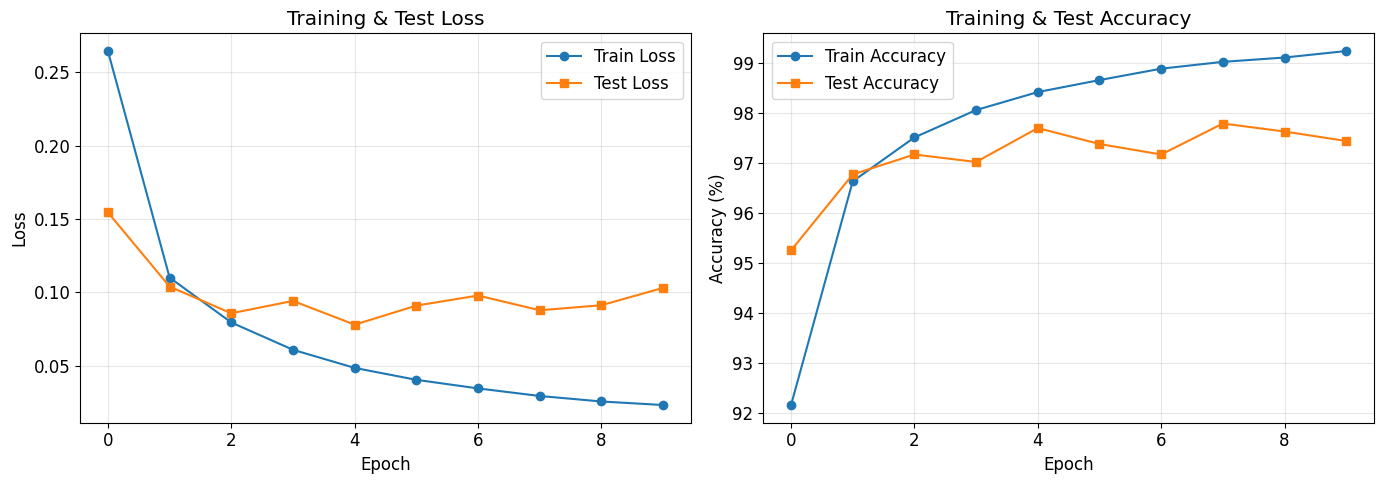

In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['test_loss'], label='Test Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['test_acc'], label='Test Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training & Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2.2 Melihat Prediksi Model

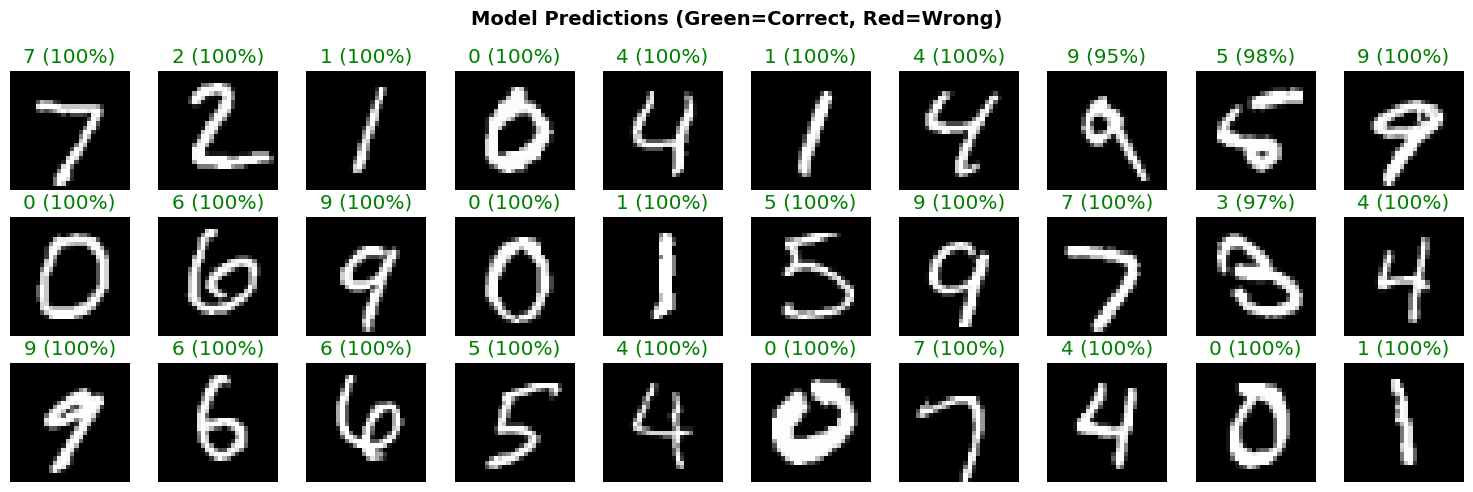

In [10]:
# Visualisasi prediksi
model.eval()
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

with torch.no_grad():
    for i in range(30):
        ax = axes[i // 10, i % 10]
        image, label = test_dataset[i]

        # Predict
        output = model(image.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1).max().item()

        # Display
        ax.imshow(image.squeeze(), cmap='gray')
        color = 'green' if pred == label else 'red'
        ax.set_title(f'{pred} ({confidence:.0%})', color=color)
        ax.axis('off')

plt.suptitle('Model Predictions (Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Part 3: Apa yang Dipelajari Hidden Layers?

## The Big Question 🤔

Network kita punya:
- **Layer 1**: 784 → 128 neurons
- **Layer 2**: 128 → 64 neurons
- **Output**: 64 → 10 neurons

**Apa yang sebenarnya dilakukan setiap layer?**

## 3.1 Intuisi: Hidden Layers sebagai Feature Extractors

Bayangkan kamu diminta mengenali angka tulisan tangan. Kamu tidak langsung melihat 784 pixel individual — kamu mencari **patterns/features**:

```
Level 1: Edges & Simple Patterns
├── Horizontal lines  ─
├── Vertical lines    │
├── Diagonal lines    / \
├── Curves            ⌒
└── Corners           ∟

Level 2: Combinations of Patterns
├── Loops             ○
├── Line intersections ┼
├── Hooks             ⌐
└── Curves + lines    ↺

Level 3: Digit-specific Features  
├── "6 has a loop at bottom"
├── "7 has horizontal top + diagonal"
├── "8 has two stacked loops"
└── etc.
```

**Hidden layers learn to detect these features automatically!**

## 3.2 Visualisasi: Apa yang "Dicari" oleh Hidden Layer 1?

Setiap neuron di Layer 1 memiliki 784 weights — satu untuk setiap pixel input.

Kita bisa reshape weights ini menjadi 28×28 untuk melihat **pattern apa yang dicari neuron tersebut**.

In [11]:
# Extract weights dari layer 1
layer1_weights = model.layer1.weight.data.cpu().numpy()
print(f"Layer 1 weights shape: {layer1_weights.shape}")
print(f"(128 neurons, each with 784 weights)")

Layer 1 weights shape: (128, 784)
(128 neurons, each with 784 weights)


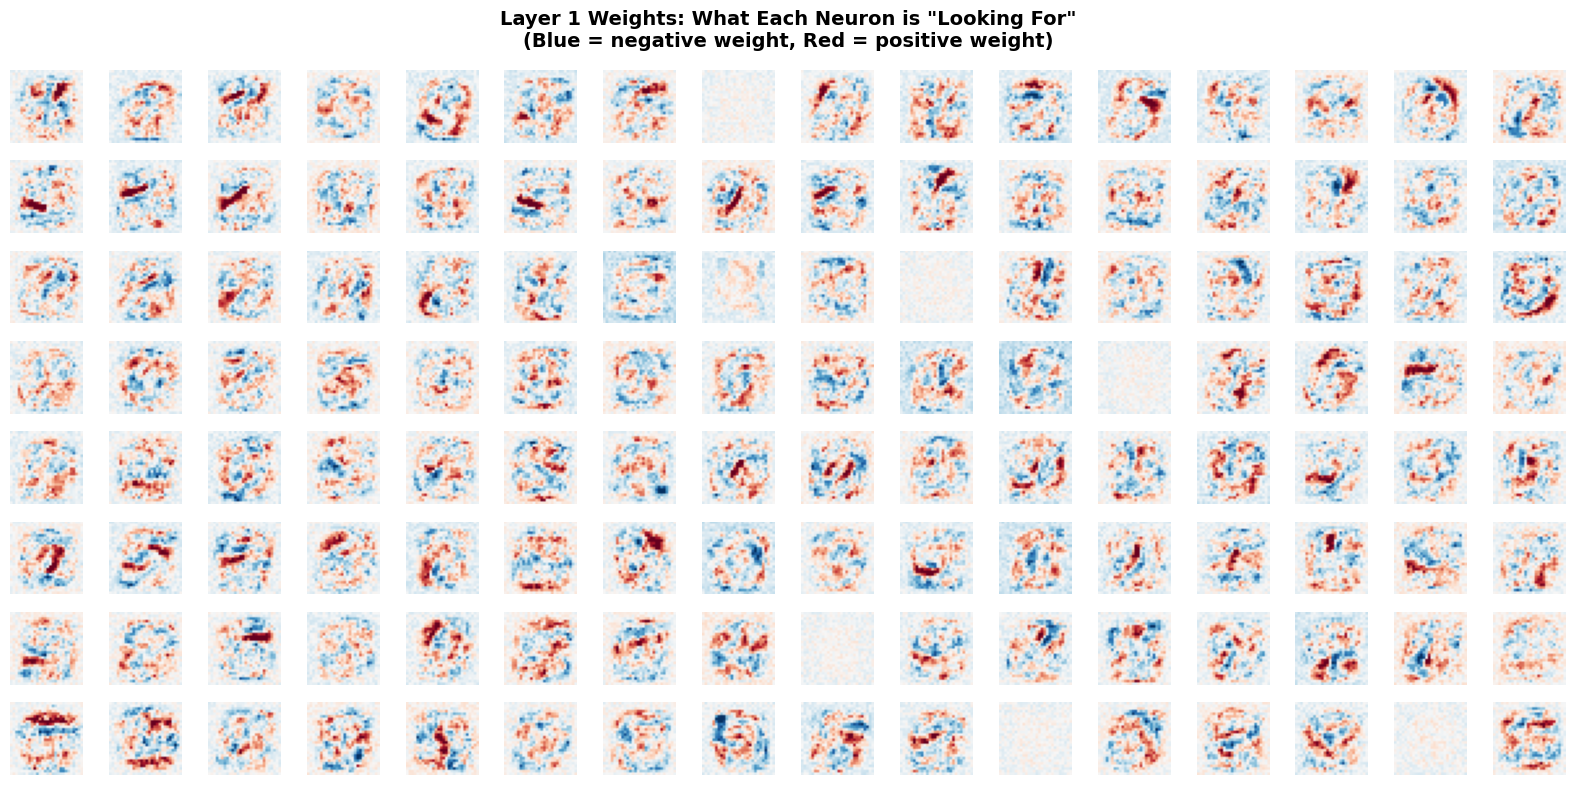

In [12]:
# Visualisasi weights sebagai "filter" atau "detector"
fig, axes = plt.subplots(8, 16, figsize=(16, 8))

for i, ax in enumerate(axes.flat):
    # Reshape weight ke 28x28
    weight_image = layer1_weights[i].reshape(28, 28)
    ax.imshow(weight_image, cmap='RdBu', vmin=-0.3, vmax=0.3)
    ax.axis('off')

plt.suptitle('Layer 1 Weights: What Each Neuron is "Looking For"\n'
             '(Blue = negative weight, Red = positive weight)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

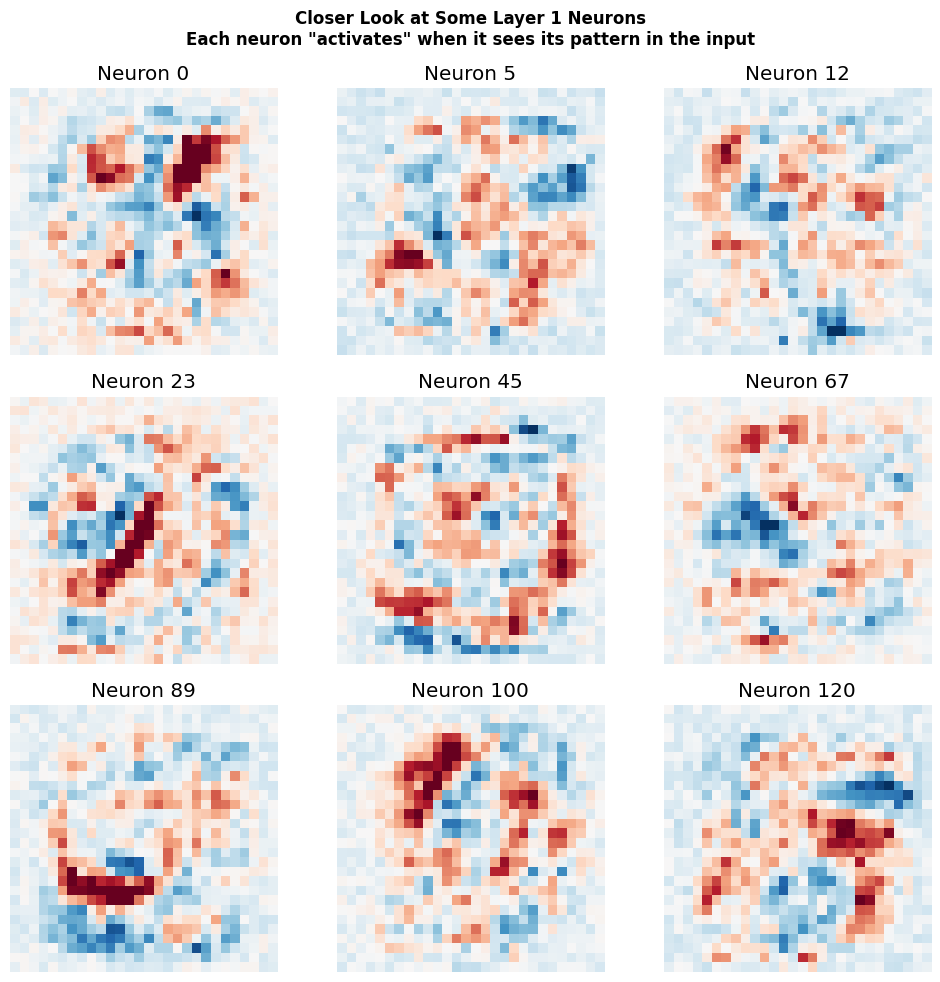

In [13]:
# Zoom in: beberapa neuron yang menarik
interesting_neurons = [0, 5, 12, 23, 45, 67, 89, 100, 120]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for ax, idx in zip(axes.flat, interesting_neurons):
    weight_image = layer1_weights[idx].reshape(28, 28)
    im = ax.imshow(weight_image, cmap='RdBu', vmin=-0.3, vmax=0.3)
    ax.set_title(f'Neuron {idx}')
    ax.axis('off')

plt.suptitle('Closer Look at Some Layer 1 Neurons\n'
             'Each neuron "activates" when it sees its pattern in the input',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 💡 Interpreting the Weights

- **Red regions**: Neuron wants HIGH pixel values here (bright pixels)
- **Blue regions**: Neuron wants LOW pixel values here (dark pixels)  
- **White/neutral**: Neuron doesn't care about this area

Setiap neuron seperti "detector" untuk pattern tertentu. Ketika input image memiliki pattern yang match, neuron akan memiliki **high activation**.

## 3.3 Visualisasi: Aktivasi untuk Input Tertentu

Sekarang kita lihat **bagaimana neurons bereaksi** ketika melihat digit tertentu.

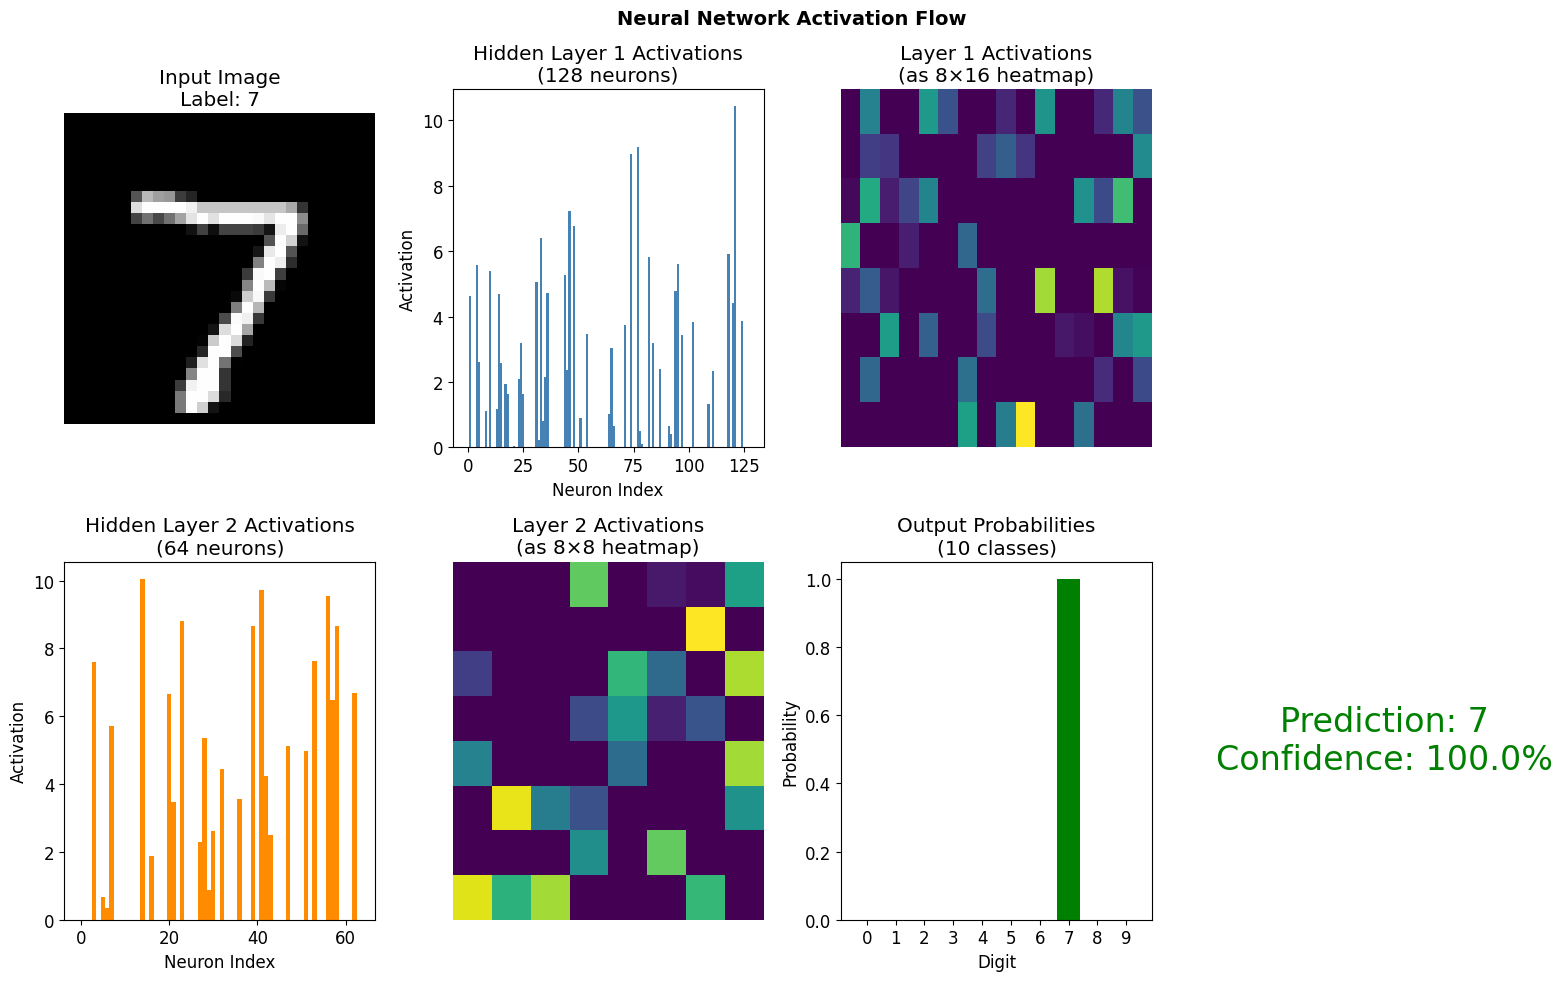

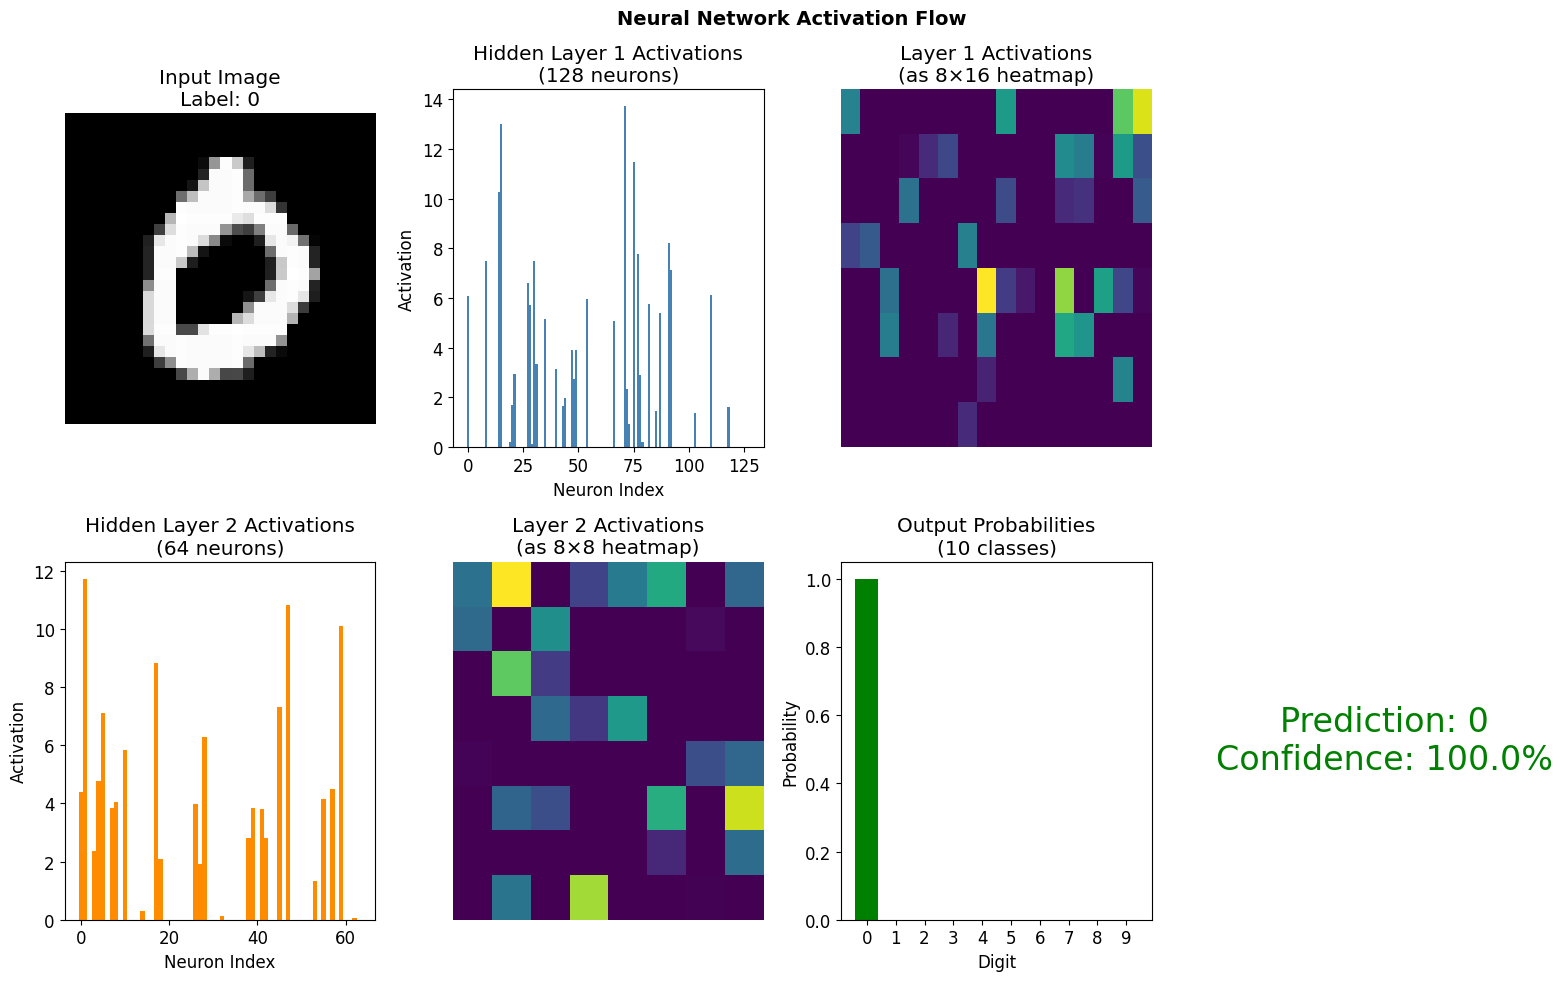

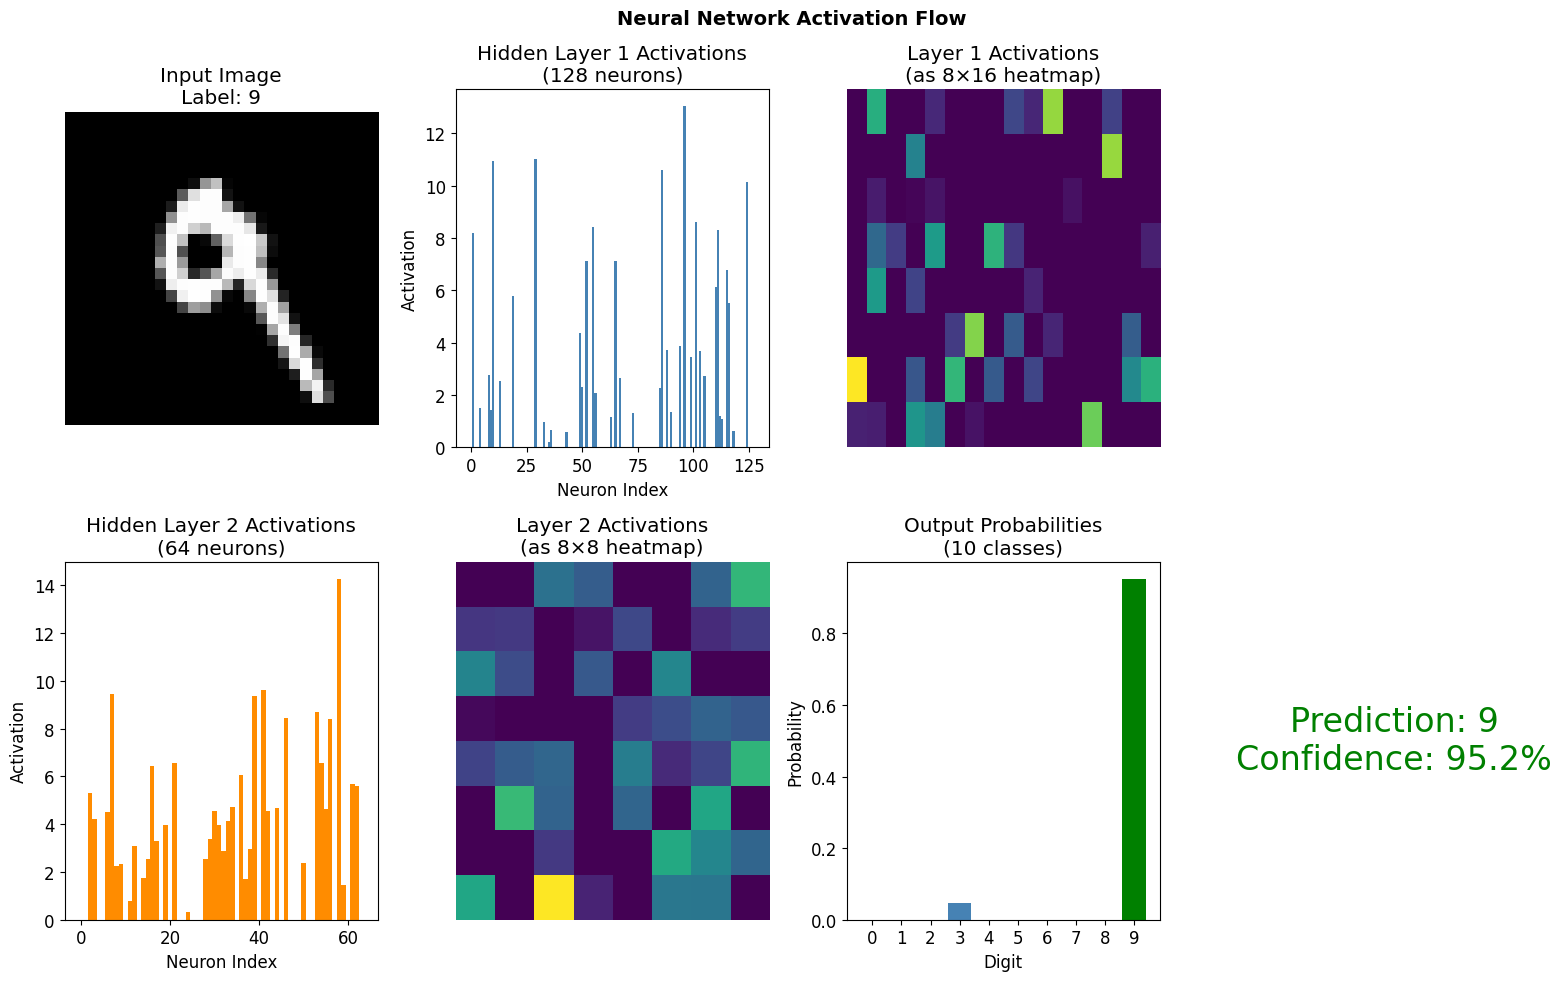

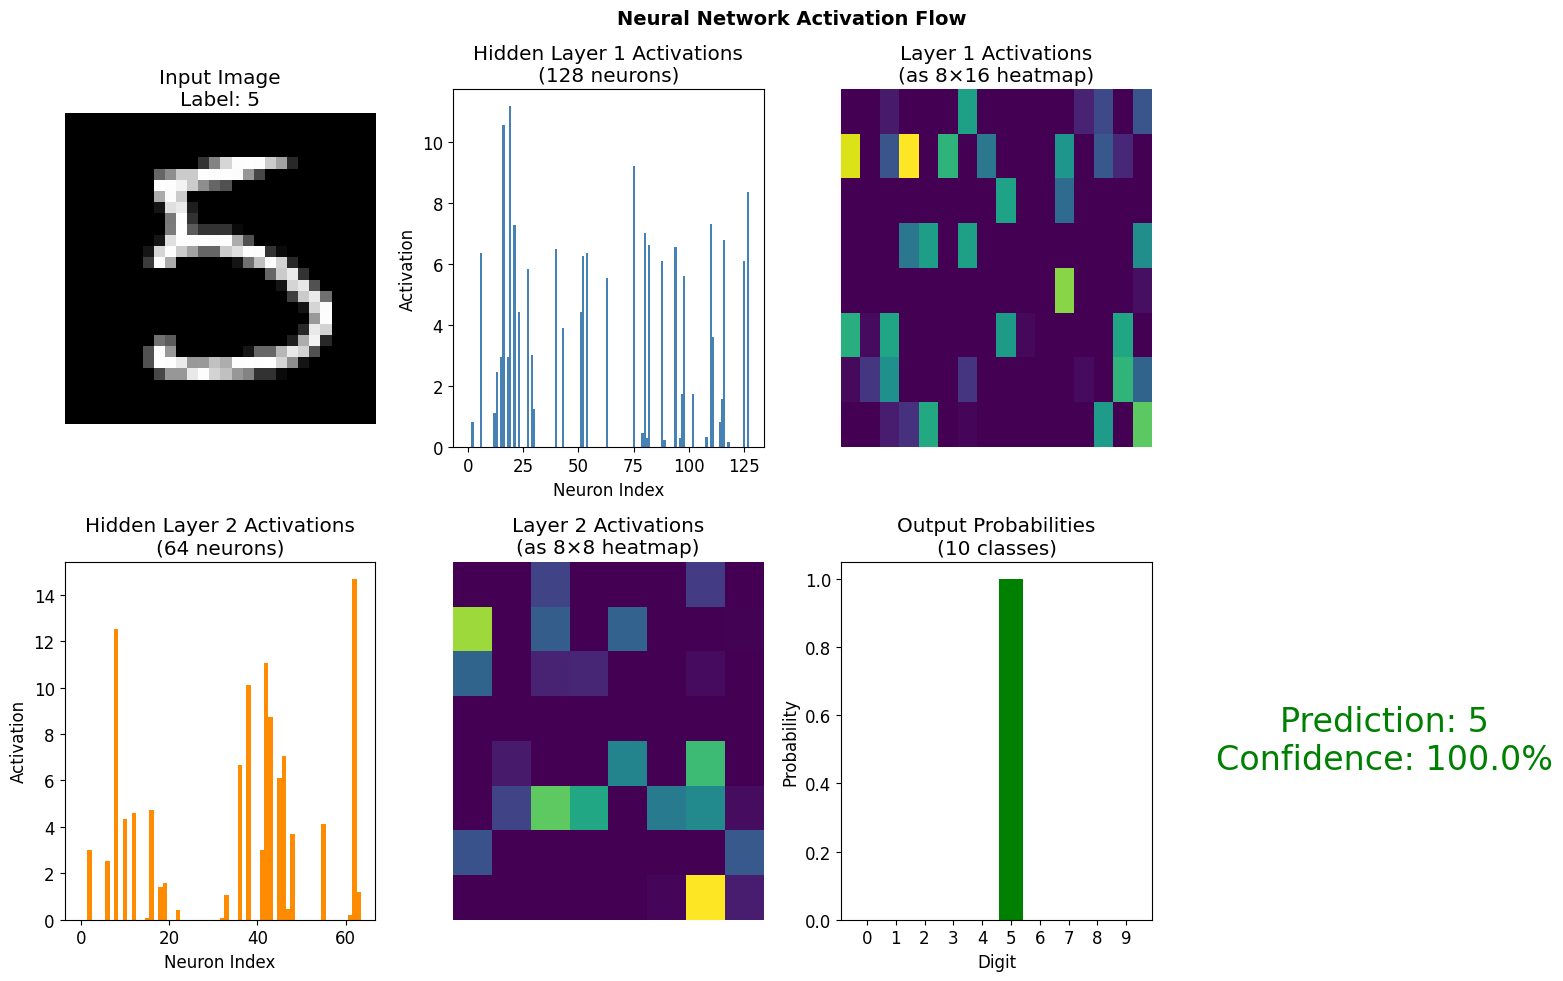

In [14]:
def visualize_activations(model, image, label):
    """Visualize activations at each layer for a given input"""
    model.eval()

    with torch.no_grad():
        activations = model.get_activations(image.unsqueeze(0).to(device))

    fig = plt.figure(figsize=(16, 10))

    # Original image
    ax1 = fig.add_subplot(2, 4, 1)
    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.set_title(f'Input Image\nLabel: {label}')
    ax1.axis('off')

    # Hidden layer 1 activations (128 neurons)
    ax2 = fig.add_subplot(2, 4, 2)
    h1_act = activations['hidden1'].cpu().numpy().flatten()
    ax2.bar(range(len(h1_act)), h1_act, color='steelblue', width=1.0)
    ax2.set_title(f'Hidden Layer 1 Activations\n(128 neurons)')
    ax2.set_xlabel('Neuron Index')
    ax2.set_ylabel('Activation')

    # Hidden layer 1 as heatmap
    ax3 = fig.add_subplot(2, 4, 3)
    h1_reshaped = h1_act.reshape(8, 16)  # Reshape for visualization
    ax3.imshow(h1_reshaped, cmap='viridis', aspect='auto')
    ax3.set_title('Layer 1 Activations\n(as 8×16 heatmap)')
    ax3.axis('off')

    # Hidden layer 2 activations (64 neurons)
    ax4 = fig.add_subplot(2, 4, 5)
    h2_act = activations['hidden2'].cpu().numpy().flatten()
    ax4.bar(range(len(h2_act)), h2_act, color='darkorange', width=1.0)
    ax4.set_title(f'Hidden Layer 2 Activations\n(64 neurons)')
    ax4.set_xlabel('Neuron Index')
    ax4.set_ylabel('Activation')

    # Hidden layer 2 as heatmap
    ax5 = fig.add_subplot(2, 4, 6)
    h2_reshaped = h2_act.reshape(8, 8)  # Reshape for visualization
    ax5.imshow(h2_reshaped, cmap='viridis', aspect='auto')
    ax5.set_title('Layer 2 Activations\n(as 8×8 heatmap)')
    ax5.axis('off')

    # Output layer (10 neurons)
    ax6 = fig.add_subplot(2, 4, 7)
    output = activations['output'].cpu().numpy().flatten()
    probs = torch.softmax(torch.tensor(output), dim=0).numpy()
    colors = ['green' if i == label else 'steelblue' for i in range(10)]
    ax6.bar(range(10), probs, color=colors)
    ax6.set_xticks(range(10))
    ax6.set_title('Output Probabilities\n(10 classes)')
    ax6.set_xlabel('Digit')
    ax6.set_ylabel('Probability')

    # Prediction
    ax7 = fig.add_subplot(2, 4, 8)
    pred = probs.argmax()
    conf = probs.max()
    ax7.text(0.5, 0.5, f'Prediction: {pred}\nConfidence: {conf:.1%}',
             ha='center', va='center', fontsize=24,
             color='green' if pred == label else 'red')
    ax7.axis('off')

    plt.suptitle('Neural Network Activation Flow', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Test dengan beberapa digit
for i in [0, 3, 7, 15]:
    image, label = test_dataset[i]
    visualize_activations(model, image, label)

## 3.4 Membandingkan Aktivasi untuk Digit Berbeda

Mari lihat bagaimana **pola aktivasi berbeda** untuk digit yang berbeda.

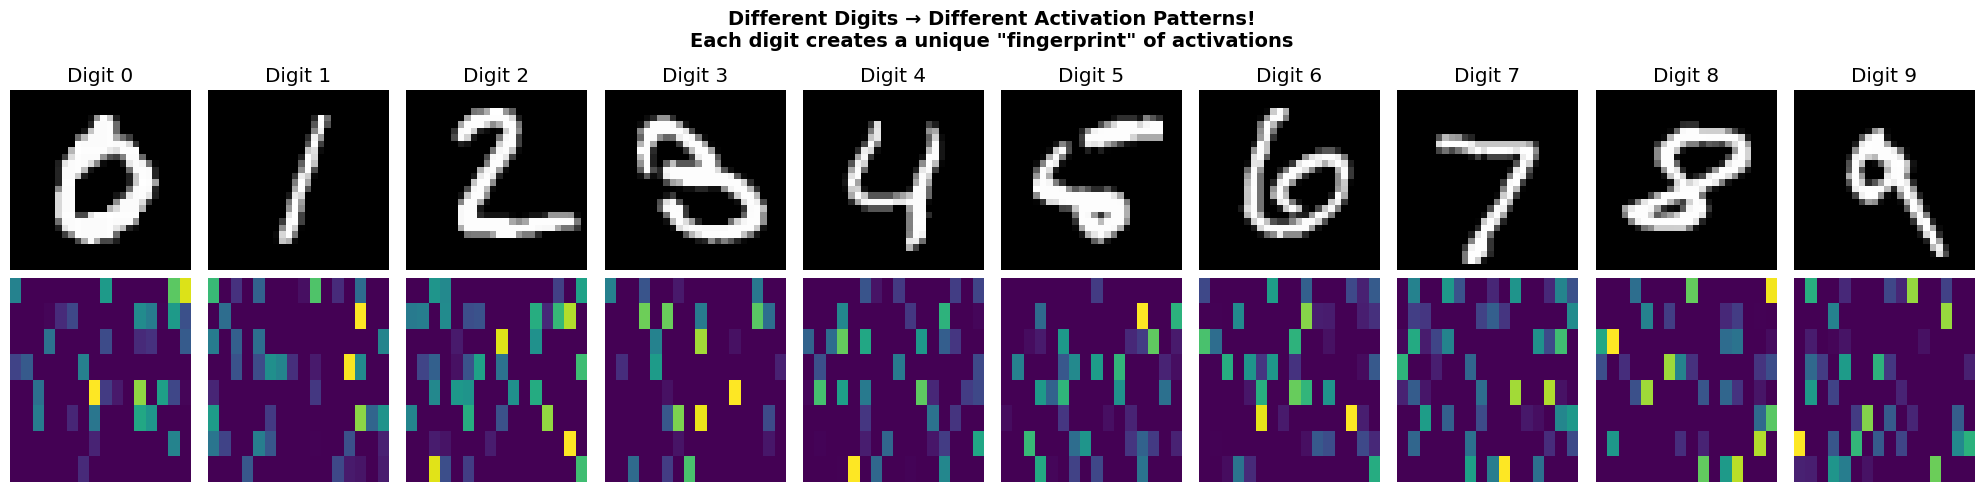

In [15]:
# Kumpulkan satu contoh untuk setiap digit
digit_examples = {}
for image, label in test_dataset:
    if label not in digit_examples:
        digit_examples[label] = image
    if len(digit_examples) == 10:
        break

# Visualisasi aktivasi Layer 1 untuk semua digit
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for digit in range(10):
    image = digit_examples[digit]

    # Get activations
    with torch.no_grad():
        activations = model.get_activations(image.unsqueeze(0).to(device))

    # Original image
    axes[0, digit].imshow(image.squeeze(), cmap='gray')
    axes[0, digit].set_title(f'Digit {digit}')
    axes[0, digit].axis('off')

    # Layer 1 activation heatmap
    h1_act = activations['hidden1'].cpu().numpy().flatten()
    h1_reshaped = h1_act.reshape(8, 16)
    axes[1, digit].imshow(h1_reshaped, cmap='viridis', aspect='auto')
    axes[1, digit].axis('off')

axes[0, 0].set_ylabel('Input', fontsize=12)
axes[1, 0].set_ylabel('Layer 1\nActivation', fontsize=12)

plt.suptitle('Different Digits → Different Activation Patterns!\n'
             'Each digit creates a unique "fingerprint" of activations',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.5 The Story: How Features Build Up

Mari kita trace **alur pemrosesan** untuk satu digit:

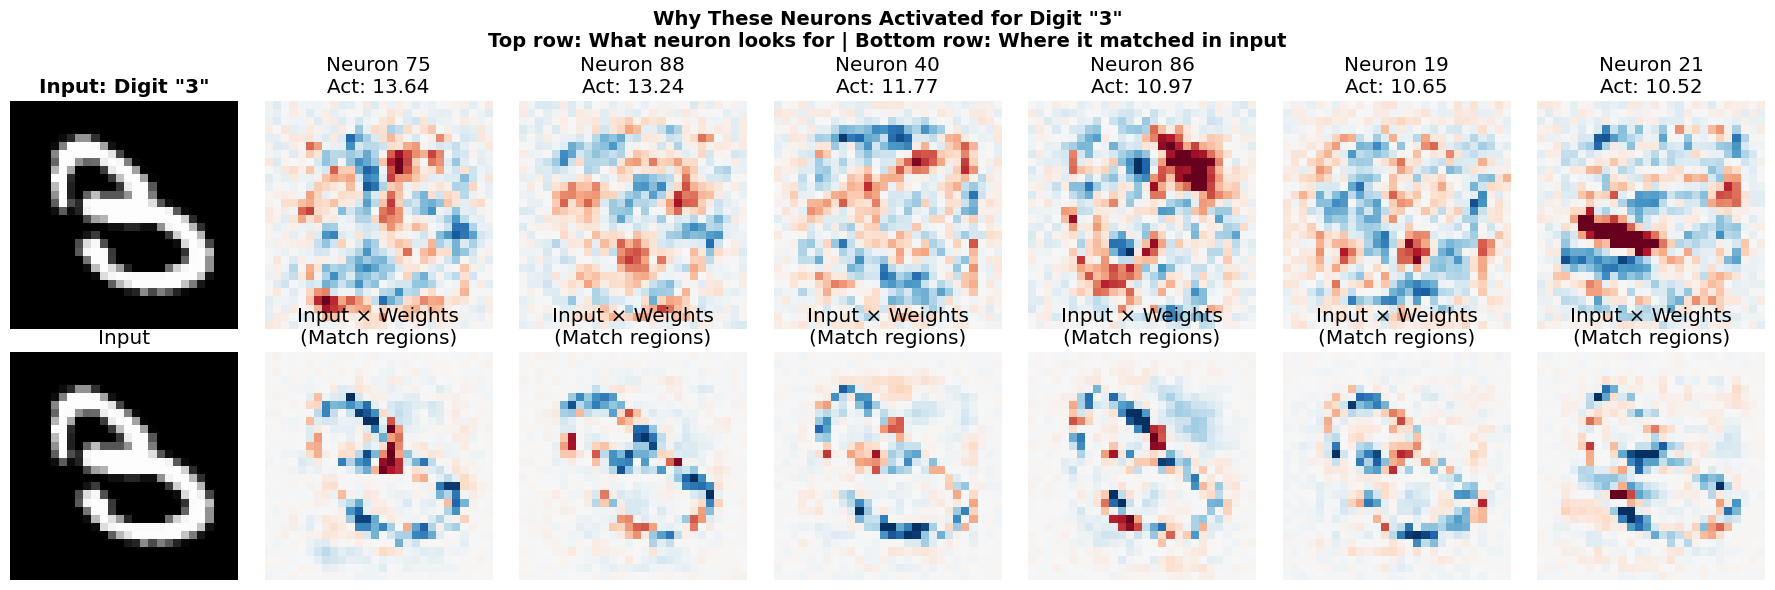

In [16]:
# Pilih digit "3" sebagai contoh
sample_image = digit_examples[3]

with torch.no_grad():
    activations = model.get_activations(sample_image.unsqueeze(0).to(device))

# Find neurons with highest activation di layer 1
h1_act = activations['hidden1'].cpu().numpy().flatten()
top_neurons = np.argsort(h1_act)[-6:][::-1]  # Top 6 activated neurons

fig, axes = plt.subplots(2, 7, figsize=(18, 6))

# Row 1: Input and top activated neurons' weights
axes[0, 0].imshow(sample_image.squeeze(), cmap='gray')
axes[0, 0].set_title('Input: Digit "3"', fontweight='bold')
axes[0, 0].axis('off')

for i, neuron_idx in enumerate(top_neurons):
    weight_image = layer1_weights[neuron_idx].reshape(28, 28)
    axes[0, i+1].imshow(weight_image, cmap='RdBu', vmin=-0.3, vmax=0.3)
    axes[0, i+1].set_title(f'Neuron {neuron_idx}\nAct: {h1_act[neuron_idx]:.2f}')
    axes[0, i+1].axis('off')

# Row 2: Overlay showing where pattern matches
axes[1, 0].imshow(sample_image.squeeze(), cmap='gray')
axes[1, 0].set_title('Input')
axes[1, 0].axis('off')

for i, neuron_idx in enumerate(top_neurons):
    weight_image = layer1_weights[neuron_idx].reshape(28, 28)
    input_flat = sample_image.squeeze().numpy()

    # Element-wise product shows where pattern matches
    match = input_flat * weight_image
    axes[1, i+1].imshow(match, cmap='RdBu', vmin=-0.5, vmax=0.5)
    axes[1, i+1].set_title(f'Input × Weights\n(Match regions)')
    axes[1, i+1].axis('off')

plt.suptitle('Why These Neurons Activated for Digit "3"\n'
             'Top row: What neuron looks for | Bottom row: Where it matched in input',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Part 4: The Big Picture — Feature Hierarchy

## Analogi: Dari Pixels ke Meaning

```
┌─────────────────────────────────────────────────────────────────────────┐
│  INPUT LAYER (784 neurons)                                              │
│  ─────────────────────────                                              │
│  "Raw pixels" - just brightness values                                  │
│  No understanding yet                                                   │
│                                                                         │
│          ↓ (learned transformations)                                    │
│                                                                         │
│  HIDDEN LAYER 1 (128 neurons)                                           │
│  ───────────────────────────                                            │
│  "Edge detectors" - looking for simple patterns                         │
│  Each neuron responds to specific local features                        │
│  Example: "Is there a horizontal line here?"                            │
│                                                                         │
│          ↓ (combine simple features)                                    │
│                                                                         │
│  HIDDEN LAYER 2 (64 neurons)                                            │
│  ──────────────────────────                                             │
│  "Part detectors" - combinations of edges                               │
│  Each neuron responds to more abstract patterns                         │
│  Example: "Is there a loop shape?" "Is there a vertical stroke?"        │
│                                                                         │
│          ↓ (combine parts into whole)                                   │
│                                                                         │
│  OUTPUT LAYER (10 neurons)                                              │
│  ─────────────────────────                                              │
│  "Digit detectors" - one neuron per digit                               │
│  Combines all features to make final decision                           │
│  Example: "Loop at top + vertical line = 9"                             │
└─────────────────────────────────────────────────────────────────────────┘
```

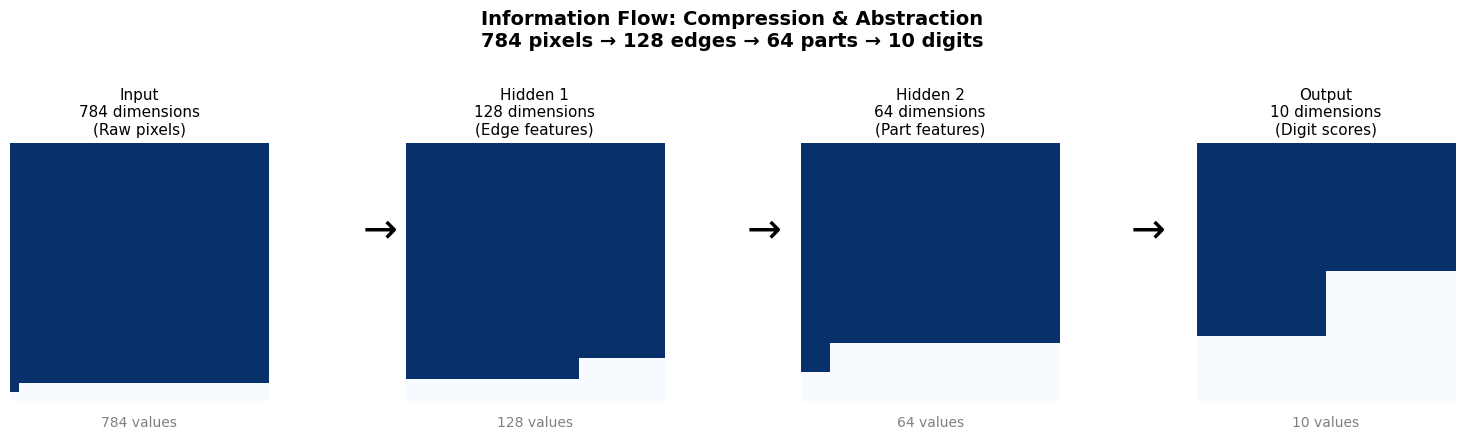

In [17]:
# Visualisasi: dimensionality reduction di setiap layer
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Info untuk setiap layer
layers_info = [
    ('Input\n784 dimensions', 784, 'Raw pixels'),
    ('Hidden 1\n128 dimensions', 128, 'Edge features'),
    ('Hidden 2\n64 dimensions', 64, 'Part features'),
    ('Output\n10 dimensions', 10, 'Digit scores')
]

for ax, (title, dim, desc) in zip(axes, layers_info):
    # Create visual representation of dimensionality
    size = int(np.sqrt(dim)) + 1
    grid = np.zeros((size, size))
    grid.flat[:dim] = 1

    ax.imshow(grid, cmap='Blues', aspect='equal')
    ax.set_title(f'{title}\n({desc})', fontsize=11)
    ax.axis('off')

    # Add dimension count
    ax.text(0.5, -0.1, f'{dim} values', transform=ax.transAxes,
            ha='center', fontsize=10, color='gray')

# Add arrows
for i in range(3):
    fig.text(0.28 + i*0.24, 0.5, '→', fontsize=30, ha='center', va='center')

plt.suptitle('Information Flow: Compression & Abstraction\n'
             '784 pixels → 128 edges → 64 parts → 10 digits',
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

## 4.1 Key Insight: Layer = Transformation = New Representation

Setiap hidden layer melakukan **transformasi** yang membuat data **lebih mudah dipisahkan**.

In [18]:
# Visualisasi: representasi data di setiap layer menggunakan t-SNE
from sklearn.manifold import TSNE

# Ambil subset data
n_samples = 1000
subset_indices = np.random.choice(len(test_dataset), n_samples, replace=False)

images = []
labels = []
for idx in subset_indices:
    img, lbl = test_dataset[idx]
    images.append(img)
    labels.append(lbl)

images_tensor = torch.stack(images).to(device)
labels_array = np.array(labels)

# Get activations di setiap layer
model.eval()
with torch.no_grad():
    all_activations = model.get_activations(images_tensor)

print("Computing t-SNE for each layer representation...")
print("(This may take a minute)")

Computing t-SNE for each layer representation...
(This may take a minute)


In [19]:
# t-SNE untuk setiap layer
layer_names = ['input', 'hidden1', 'hidden2']
tsne_results = {}

for name in layer_names:
    print(f"Processing {name}...")
    data = all_activations[name].cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results[name] = tsne.fit_transform(data)

print("Done!")

Processing input...
Processing hidden1...
Processing hidden2...
Done!


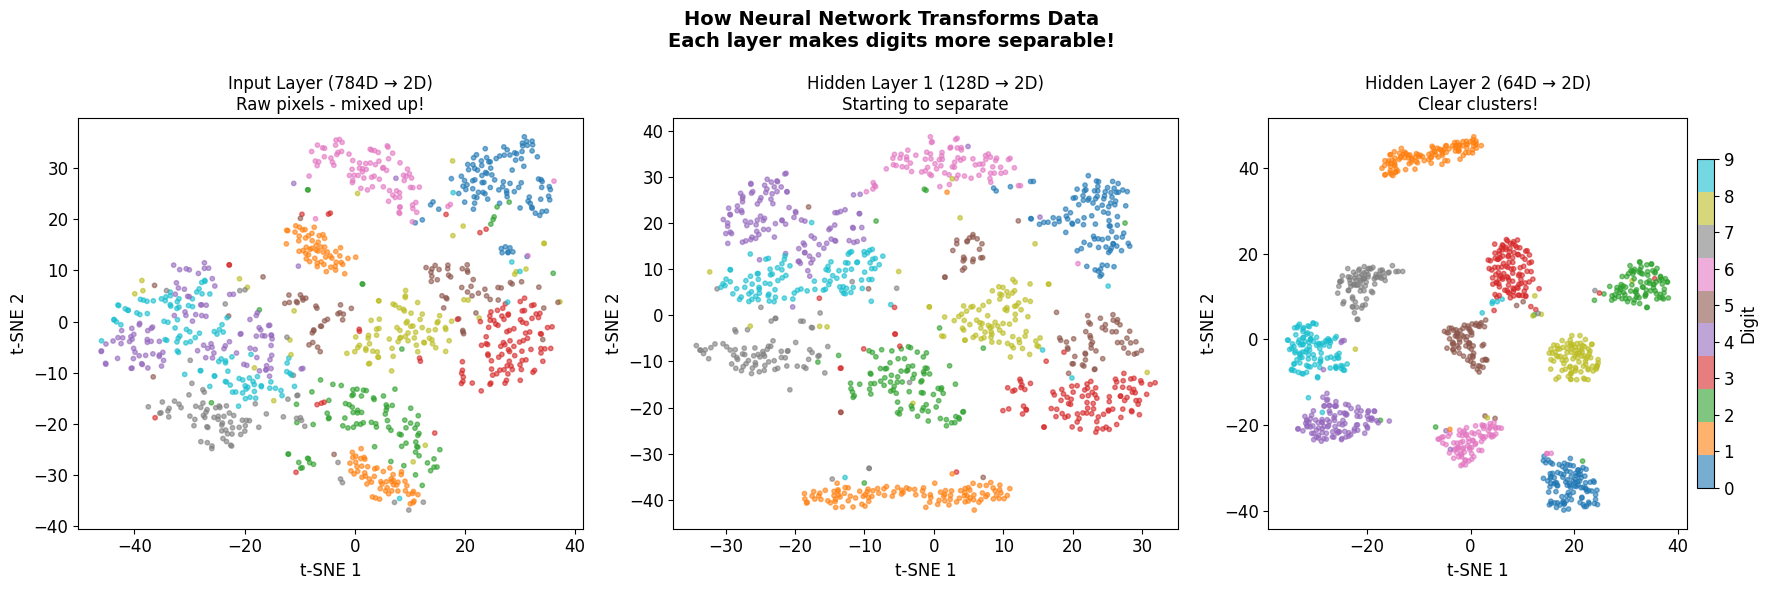

In [20]:
# Plot t-SNE results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

layer_titles = [
    'Input Layer (784D → 2D)\nRaw pixels - mixed up!',
    'Hidden Layer 1 (128D → 2D)\nStarting to separate',
    'Hidden Layer 2 (64D → 2D)\nClear clusters!'
]

for ax, name, title in zip(axes, layer_names, layer_titles):
    scatter = ax.scatter(tsne_results[name][:, 0],
                         tsne_results[name][:, 1],
                         c=labels_array, cmap='tab10',
                         vmin=0, vmax=9,
                         alpha=0.6, s=10)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

# Colorbar di axis terakhir saja
cbar = fig.colorbar(scatter, ax=axes[-1], shrink=0.8, pad=0.02)
cbar.set_label('Digit', fontsize=12)
cbar.set_ticks(range(10))

plt.suptitle('How Neural Network Transforms Data\n'
             'Each layer makes digits more separable!',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 💡 The Magic of Hidden Layers!

Perhatikan bagaimana:

1. **Input layer**: Digit-digit masih tercampur — pixel values saja tidak cukup
2. **Hidden layer 1**: Mulai ada separasi — features mulai berguna
3. **Hidden layer 2**: Cluster yang jelas! — siap untuk classification

**Inilah yang dipelajari neural network: transformasi yang membuat data mudah dipisahkan!**

---
# Part 5: Putting It All Together

## Summary: What Hidden Layers Do

| Layer | Input | Output | What It Learns |
|-------|-------|--------|----------------|
| Input | Image pixels | 784 values | Nothing (just raw data) |
| Hidden 1 | 784 values | 128 values | Low-level features (edges, strokes) |
| Hidden 2 | 128 values | 64 values | Higher-level features (parts, shapes) |
| Output | 64 values | 10 values | Digit classification scores |

## The Key Insights

1. **Hidden layers = Feature extractors**
   - Each neuron learns to detect specific patterns
   - Neurons "activate" when they see their pattern

2. **Hierarchy of features**
   - Early layers: Simple features (edges, textures)
   - Later layers: Complex features (parts, objects)
   - Output layer: Task-specific decision

3. **Learned representations**
   - Network learns to transform data into separable form
   - Each layer's output is a new "view" of the data
   - Better representations → easier classification

---
# 🎯 Exercises

## Bagian A: Eksplorasi Model

1. **Vary network depth**: Buat network dengan 1, 2, 3, dan 4 hidden layers. Bandingkan akurasi dan training time. Apakah lebih dalam selalu lebih baik?

2. **Vary network width**: Coba hidden layer sizes: [32], [64], [128], [256], [512]. Plot accuracy vs number of parameters.

3. **Activation comparison**: Ganti ReLU dengan Sigmoid dan Tanh. Bandingkan (a) final accuracy, (b) training speed, (c) weight visualizations.

## Bagian B: Analisis Representasi

4. **Similar digits**: Pilih digit yang sering tertukar (misalnya 3 dan 8, atau 4 dan 9). Visualisasikan aktivasi mereka — apa yang mirip dan berbeda?

5. **Misclassified examples**: Temukan contoh yang salah diklasifikasi. Analisis: (a) Seperti apa gambarnya? (b) Bagaimana pola aktivasinya? (c) Kenapa model "bingung"?

6. **Neuron surgery**: Setelah training, set semua weights di satu neuron hidden layer menjadi 0. Apa yang terjadi pada akurasi? Coba untuk beberapa neuron berbeda.

## Bagian C: Eksperimen Lanjutan

7. **Data augmentation effect**: Tambahkan random rotation (±15°) pada training data. Apakah akurasi meningkat? Bagaimana weight visualizations berubah?

8. **Dropout experiment**: Tambahkan `nn.Dropout(0.5)` setelah setiap hidden layer. Bandingkan train vs test accuracy dengan dan tanpa dropout.

9. **Learning rate exploration**: Plot training curves untuk learning rates: 0.0001, 0.001, 0.01, 0.1. Mana yang terbaik? Apa yang terjadi kalau terlalu besar/kecil?

10. **Fashion-MNIST challenge**: Ganti dataset ke Fashion-MNIST (baju, sepatu, dll). Apakah arsitektur yang sama bekerja? Apa yang perlu diubah untuk hasil lebih baik?

In [21]:
# Space for your experiments!

